In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2 as cv
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg19 import VGG19
#EfficientNetV2L
#from keras.applications.efficientnet import EfficientNetV2L
from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.ensemble import VotingClassifier

In [2]:
def input_data(folder_path, output_data):    #importing the data into the output_data list
    for dirs in os.listdir(folder_path):
        class_name = dirs
        new_path = os.path.join(folder_path, class_name)
        for img in os.listdir(new_path):
            img_arr = cv.imread(os.path.join(new_path, img), cv.IMREAD_COLOR)
            resize = cv.resize(img_arr, (128,128))
            img = cv.cvtColor(img_arr, cv.COLOR_RGB2BGR)
            output_data.append([resize, class_name])
    return output_data

In [3]:
train_data = input_data(r"C:\Users\lenovo\Documents\dataset\melanoma_cancer_dataset\train", [])
test_data = input_data(r"C:\Users\lenovo\Documents\dataset\melanoma_cancer_dataset\test", [])

In [4]:
np.random.shuffle(train_data)   #shuffling the data
np.random.shuffle(test_data)

In [5]:
X_train = []              #separating the image and labels from the train_data list
Y_train = []
for features, labels in train_data:
    X_train.append(features)
    Y_train.append(labels)

In [6]:
X_test = []    #separating the image and labels from the test_data list
Y_test = []
for features, labels in test_data:
    X_test.append(features)
    Y_test.append(labels)

In [7]:
#Convert lists to arrays
test_images = np.array(X_test)
test_labels = np.array(Y_test)

In [8]:
train_images = np.array(X_train)
train_labels = np.array(Y_train)

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
y_train[10:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 0])

In [12]:
x_train.shape

(9605, 128, 128, 3)

In [13]:
# np.save('/content/drive/MyDrive/Modified_code/numpy_on_disk/train_on_disk.npy', x_train)
# np.save('/content/drive/MyDrive/Modified_code/numpy_on_disk/test_on_disk.npy', x_test)

In [14]:
# import mmap

# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

# from tsai.all import *
# my_setup()

# print(f'X array: {os.path.getsize("/content/drive/MyDrive/Modified_code/numpy_on_disk/train_on_disk.npy"):12} bytes ({bytes2GB(os.path.getsize("/content/drive/MyDrive/Modified_code/numpy_on_disk/train_on_disk.npy")):3.2f} GB)')
# print(f'y array: {os.path.getsize("/content/drive/MyDrive/Modified_code/numpy_on_disk/test_on_disk.npy"):12} bytes ({bytes2GB(os.path.getsize("/content/drive/MyDrive/Modified_code/numpy_on_disk/test_on_disk.npy")):3.2f} GB)')

In [15]:
# X_on_disk = np.load('/content/drive/MyDrive/Modified_code/numpy_on_disk/train_on_disk.npy', mmap_mode='c')
# y_on_disk = np.load('/content/drive/MyDrive/Modified_code/numpy_on_disk/test_on_disk.npy', mmap_mode='c')

In [16]:
# # Normalize pixel values to between 0 and 1

In [17]:
labels=np.unique(y_test)
labels

array([0, 1])

In [18]:
#One hot encode y values for neural network.
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Vision Transformer

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(key_dim=embed_dim, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feedforward network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return layers.LayerNormalization(epsilon=1e-6)(x + inputs)

def ViT(input_shape, num_classes, num_transformer_blocks, embed_dim, num_heads, ff_dim, dropout=0):
    inputs = layers.Input(shape=input_shape)

    # CNN backbone
    x = layers.Conv2D(64, kernel_size=3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(128, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    # Add a global average pooling layer to reduce the spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)

    # Reshape the CNN output to a compatible format for the transformer blocks
    x = layers.Reshape((-1, x.shape[-1]))(x)

    for _ in range(num_transformer_blocks):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, dropout)

#     x = layers.Flatten()(x)
# #     x = layers.Dense(256, activation="relu")(x)
#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs,x)

# Example usage:
input_shape = (128, 128, 3)  # Replace with your image input shape
num_classes = 2  # Number of classes for classification
num_transformer_blocks = 4  # Number of transformer blocks
embed_dim = 32  # Dimension of transformer embeddings
num_heads = 8  # Number of attention heads in transformer blocks
ff_dim = 32  # Feedforward dimension in transformer blocks

# vip_cnn_model = build_vip_cnn(input_shape, num_classes, num_transformer_blocks, embed_dim, num_heads, ff_dim)
# vip_cnn_model.summary()


In [20]:
Model = ViT(input_shape, num_classes, num_transformer_blocks, embed_dim, num_heads, ff_dim)

In [21]:
for layer in Model.layers:
	layer.trainable = False

Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 128)          73856     ['max_pooling2d[0][0]']   

 layer_normalization_4 (Lay  (None, 1, 128)               256       ['tf.__operators__.add_4[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 1, 32)                4128      ['layer_normalization_4[0][0]'
                                                                    ]                             
                                                                                                  
 dropout_5 (Dropout)         (None, 1, 32)                0         ['conv1d_4[0][0]']            
                                                                                                  
 conv1d_5 (Conv1D)           (None, 1, 128)               4224      ['dropout_5[0][0]']           
                                                                                                  
 tf.__oper

#**Feature Extraction - 1st CNN MODEL**

##_

In [22]:
#Now, let us use features from convolutional network for RF
feature_extractor__=Model.predict(x_train)

301/301 [==============================] - 32s 104ms/step


In [23]:
fe___test=Model.predict(x_test)
#fe___test=MobileNet_model.predict(x_test)

32/32 [==============================] - 3s 102ms/step


In [24]:
features__ = feature_extractor__.reshape(feature_extractor__.shape[0], -1)

In [25]:
f___test=fe___test.reshape(fe___test.shape[0],-1)

In [26]:
print(f___test.shape)

(1000, 128)


In [27]:
# X_for_RF = features__ #This is our X input to RF

#Machine Learning Models For Classifications

##K-Nearest Neighbours

In [28]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('seaborn-whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [29]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(features__ , y_train)
y_pred=knn.predict(f___test)

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred)
acc

0.875

In [31]:
precision_score(y_test,y_pred,average='micro')

0.875

In [32]:
recall_score(y_test,y_pred,average='micro')

0.875

In [33]:
f1_score(y_test,y_pred,average='micro')

0.875

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix

In [35]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[472,  28],
       [ 97, 403]], dtype=int64)

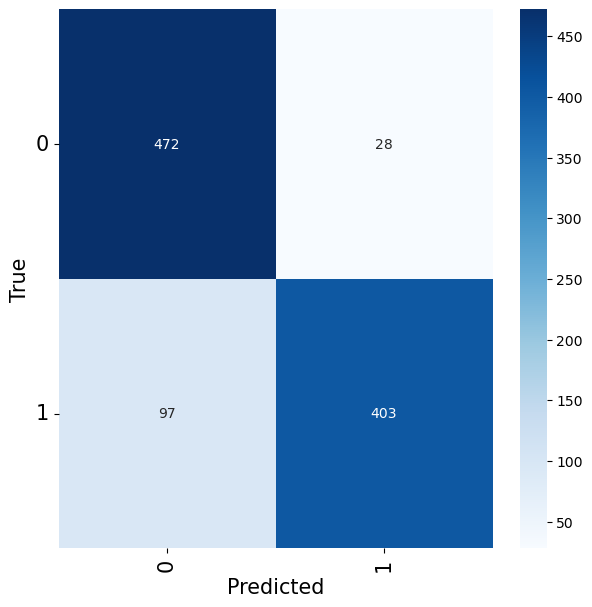

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_KNN.png')
plt.show()

##Logistic Regression

###Used In  Binary and Multiclass Classifications

In [37]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [38]:
features__.shape

(9605, 128)

In [39]:
...
# define the multinomial logistic regression model
lrm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lrm.fit(features__ , y_train)
y_pred_lr=lrm.predict(f___test)

C:\Users\lenovo\anaconda33\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred_lr)
acc

0.886

In [41]:
precision_score(y_test,y_pred_lr,average=None)

array([0.86278195, 0.91239316])

In [42]:
recall_score(y_test,y_pred_lr,average=None)

array([0.918, 0.854])

In [43]:
f1_score(y_test,y_pred_lr,average=None)

array([0.88953488, 0.8822314 ])

In [44]:
cm = confusion_matrix(y_test,y_pred_lr)
cm

array([[459,  41],
       [ 73, 427]], dtype=int64)

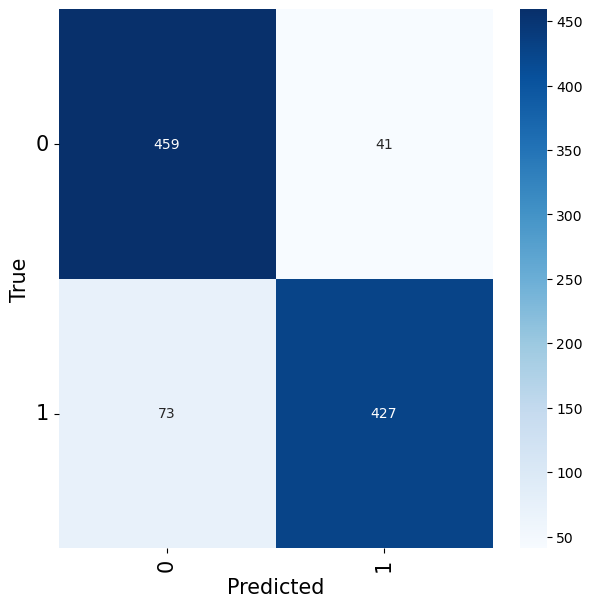

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/XceptionLR.png')
plt.show()

In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred_lr)
acc

0.886

In [47]:
# precision_score(y_test,y_pred,average=None)

In [48]:
# metrics.f1_score(y_test,y_pred,average=None)

##Random Forest

In [49]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [50]:
# Train the model on training data
RF_model.fit(features__, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [51]:
print(RF_model.score(features__, y_train))

0.9998958875585633


In [52]:
#Send test data through same feature extractor process
X_test_feature = Model.predict(x_test)



32/32 [==============================] - 3s 107ms/step


In [53]:
X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [54]:
print(X_test_feature.shape)

(1000, 1, 128)


In [55]:
#Now predict using the trained RF model.
prediction_RF = RF_model.predict(X_test_features__)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

In [56]:
print(prediction_RF.shape)

(1000,)


In [57]:
print(test_labels.shape)

(1000,)


In [58]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.896


In [59]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))
print("Precision =", precision_score(test_labels,prediction_RF,average='micro'))
print("Recall =",recall_score(test_labels,prediction_RF,average='micro'))
print("F_1 =", f1_score(test_labels,prediction_RF,average='micro'))

Accuracy =  0.896
Precision = 0.896
Recall = 0.896
F_1 = 0.8960000000000001


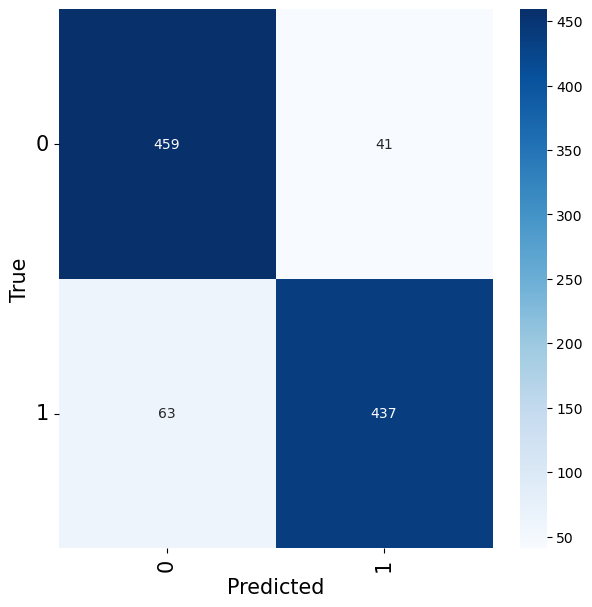

In [60]:
cm = confusion_matrix(test_labels,prediction_RF)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_RandomForest.png')
plt.show()

##XGBoost

In [61]:
import xgboost as xgb

In [62]:
xgb_classifier = xgb.XGBClassifier(tree_method = "auto")

In [63]:
xgb_classifier.fit(features__, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [64]:
predictions = xgb_classifier.predict(X_test_features__)
prediction_XG = le.inverse_transform(predictions)

In [65]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_XG))

Accuracy of Model:: 0.899


In [66]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_XG))
print("Precision =", precision_score(test_labels, prediction_XG,average='micro'))
print("Recall =",recall_score(test_labels, prediction_XG,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_XG,average='micro'))

Accuracy =  0.899
Precision = 0.899
Recall = 0.899
F_1 = 0.899


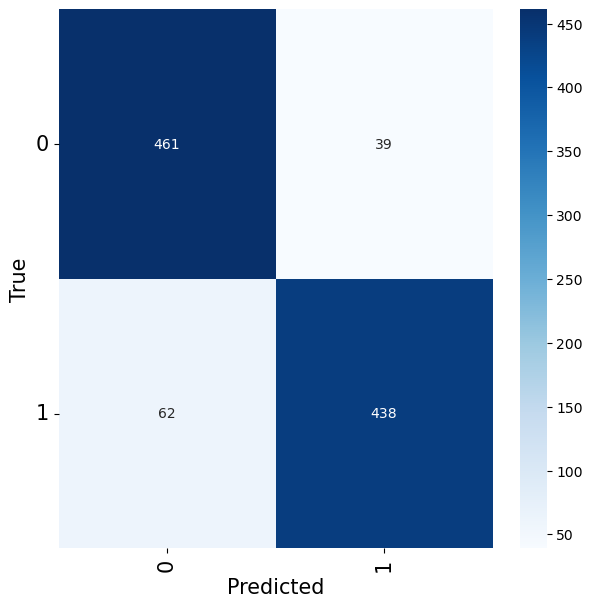

In [67]:
cm = confusion_matrix(test_labels, prediction_XG)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_XGBoost.png')
plt.show()

##SVC- Support Vector Classifier

In [68]:
from sklearn.svm import SVC

In [69]:
svc = SVC(C=0.65, random_state=0, kernel='rbf')

In [70]:
svc.fit(features__, y_train)

SVC(C=0.65, random_state=0)

In [71]:
X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)
X_test_features__.shape

(1000, 128)

In [72]:
X_test_features = Model.predict(x_test)
X_test_features.shape

32/32 [==============================] - 3s 101ms/step


(1000, 1, 128)

In [73]:
predictions = svc.predict(X_test_features__ )
prediction_SVC = le.inverse_transform(predictions)

In [74]:
prediction_SVC

array(['malignant', 'benign', 'malignant', 'benign', 'malignant',
       'benign', 'malignant', 'benign', 'benign', 'benign', 'benign',
       'benign', 'malignant', 'benign', 'benign', 'malignant',
       'malignant', 'benign', 'malignant', 'malignant', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'benign', 'benign',
       'malignant', 'malignant', 'malignant', 'malignant', 'benign',
       'malignant', 'malignant', 'benign', 'benign', 'malignant',
       'malignant', 'benign', 'benign', 'benign', 'benign', 'benign',
       'malignant', 'benign', 'malignant', 'malignant', 'benign',
       'benign', 'benign', 'malignant', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'malignant',
       'benign', 'benign', 'benign', 'benign', 'benign', 'malignant',
       'benign', 'benign', 'benign', 'malignant', 'benign', 'benign',
       'malignant', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'm

In [75]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_SVC))

Accuracy of Model:: 0.811


In [76]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))
print("Precision =", precision_score(test_labels, prediction_SVC,average='micro'))
print("Recall =",recall_score(test_labels, prediction_SVC,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_SVC,average='micro'))

Accuracy =  0.811
Precision = 0.811
Recall = 0.811
F_1 = 0.811


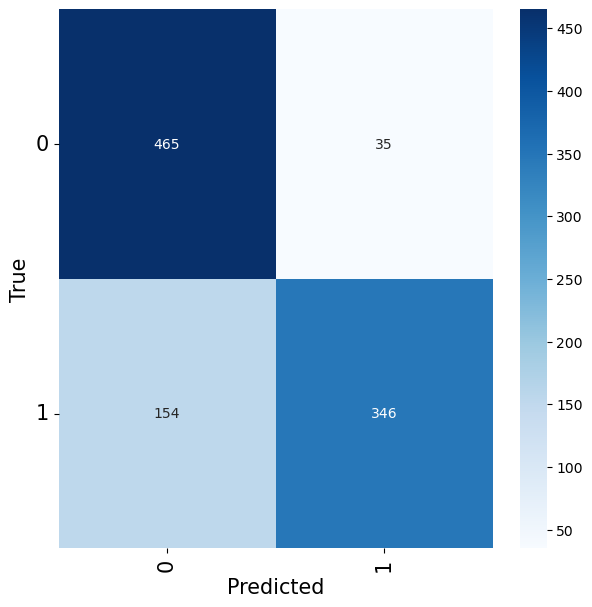

In [77]:
cm = confusion_matrix(test_labels, prediction_SVC)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_SVC.png')
plt.show()

In [78]:
# svc_1 = SVC(C=1, random_state=0, kernel='linear')

In [79]:
# svc_1.fit(features__, y_train)

In [80]:
# X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)
# X_test_features__.shape

In [81]:
# X_test_features = Model.predict(x_test)
# X_test_features.shape

In [82]:
# predictions = svc_1.predict(X_test_features__ )
# prediction_SVC = le.inverse_transform(predictions)

In [83]:
# prediction_SVC

In [84]:
# print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))
# print("Precision =", precision_score(test_labels, prediction_SVC,average='micro'))
# print("Recall =",recall_score(test_labels, prediction_SVC,average='micro'))
# print("Recall =", f1_score(test_labels, prediction_SVC,average='micro'))

In [85]:
import numpy as np
from sklearn.manifold import TSNE
#>>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(features__)
X_embedded.shape

(9605, 3)

In [86]:
import pandas as pd

In [87]:
from sklearn.naive_bayes import GaussianNB

# Create an instance of the GaussianNB classifier
# classfier_1 = GaussianNB()

In [88]:
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = X_embedded[:,0]
df["comp-2"] = X_embedded[:,1]

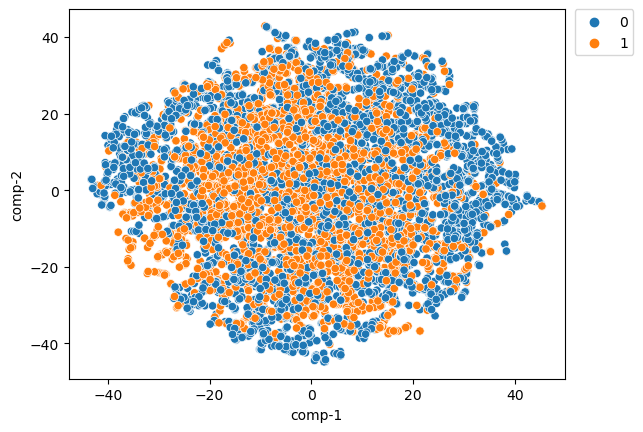

In [89]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig('/home/nd/Ankit-Deepto-Btech/__128_128/TSNE_Train_data.png')
plt.show()

In [90]:
# classfier_1.fit(features__, y_train)

In [91]:
# predictions_1 = classfier_1.predict(X_test_features__ )
# prediction_1 = le.inverse_transform(predictions_1)

In [92]:
# print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_1))

##ENSEMBLE

In [93]:
final_model = VotingClassifier(estimators=[('rf', RF_model), ('xgb', xgb_classifier),('knn',knn),('svc',svc),('lr',lrm)], voting='hard')


In [94]:
final_model.fit(features__, y_train)

C:\Users\lenovo\anaconda33\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=Non...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('svc', SVC(C=0.65, random_state=0)),
                             ('lr',
                              LogisticRegression(multi_class='multinomial'))])

In [95]:
predictions = final_model.predict(X_test_features__) # X_test_features
prediction_final = le.inverse_transform(predictions)

In [96]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_final))

Accuracy of Model:: 0.899


In [97]:
print("Precision =", precision_score(test_labels, prediction_final,average='micro'))
print("Recall =",recall_score(test_labels, prediction_final,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_final,average='micro'))

Precision = 0.899
Recall = 0.899
F_1 = 0.899


In [98]:
print("Accuracy =",accuracy_score(test_labels, prediction_final))
print("Precision =", precision_score(test_labels, prediction_final,average=None))
print("Recall =",recall_score(test_labels, prediction_final,average=None))
print("F_1 =", f1_score(test_labels, prediction_final,average=None))

Accuracy = 0.899
Precision = [0.86605505 0.93846154]
Recall = [0.944 0.854]
F_1 = [0.90334928 0.89424084]


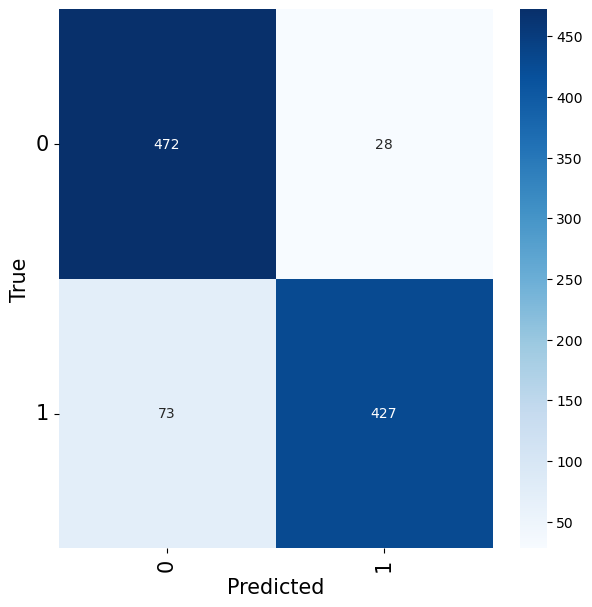

In [99]:
cm = confusion_matrix(test_labels, prediction_final)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_Ensemble.png')
plt.show()

# CapsNet

In [100]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom Capsule Layer
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsules * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, inputs):
        # Expand dimensions to handle routing iterations
        inputs_expand = tf.expand_dims(inputs, axis=2)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsules, 1])

        # Perform matrix multiplication between W and inputs
        input_hat = tf.matmul(inputs_tiled, self.W)

        # Routing algorithm
        b = tf.zeros(shape=[tf.shape(inputs)[0], tf.shape(inputs)[1], self.num_capsules])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            outputs = self.squash(tf.reduce_sum(c[..., tf.newaxis] * input_hat, axis=1, keepdims=True))

            if i < self.routings - 1:
                b += tf.reduce_sum(input_hat * outputs, axis=-1)

        return tf.squeeze(outputs, axis=1)

    def squash(self, vector):
        squared_norm = tf.reduce_sum(tf.square(vector), axis=-1, keepdims=True)
        safe_norm = tf.sqrt(squared_norm + tf.keras.backend.epsilon())
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = vector / safe_norm
        return squash_factor * unit_vector

# Building the CNN + Capsule Network Model
def CapsNet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # CNN Backbone
    x = layers.Conv2D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)

    # Capsule Layer
    x = layers.Reshape((-1, 64))(x)
    x = CapsuleLayer(num_capsules=num_classes, dim_capsule=16, routings=3)(x)

    # Final Classification
#     x = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1)), name='norm')(x)
    outputs = layers.Activation('softmax')(x)

    return models.Model(inputs, x)

# Example usage:
input_shape = (128, 128, 3)  # Replace with your image input shape
num_classes = 2  # Number of classes for classification

# caps_cnn_model = build_caps_cnn(input_shape, num_classes)
# caps_cnn_model.summary()


In [101]:
Model = CapsNet(input_shape, num_classes)

In [102]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Model.layers:
	layer.trainable = False

Model.summary()  #Trainable parameters will be 0

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0   

In [103]:
#Now, let us use features from convolutional network for RF
feature_extractor__=Model.predict(x_train)

301/301 [==============================] - 20s 66ms/step


In [104]:
fe___test=Model.predict(x_test)
#fe___test=MobileNet_model.predict(x_test)

32/32 [==============================] - 2s 64ms/step


In [105]:
features__ = feature_extractor__.reshape(feature_extractor__.shape[0], -1)

In [106]:
f___test=fe___test.reshape(fe___test.shape[0],-1)

In [107]:
print(f___test.shape)

(1000, 64)


In [108]:
# X_for_RF = features__ #This is our X input to RF

#Machine Learning Models For Classifications

##K-Nearest Neighbours

In [109]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('seaborn-whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [110]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(features__ , y_train)
y_pred=knn.predict(f___test)

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred)
acc

0.849

In [112]:
precision_score(y_test,y_pred,average='micro')

0.849

In [113]:
recall_score(y_test,y_pred,average='micro')

0.849

In [114]:
f1_score(y_test,y_pred,average='micro')

0.849

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix

In [116]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[458,  42],
       [109, 391]], dtype=int64)

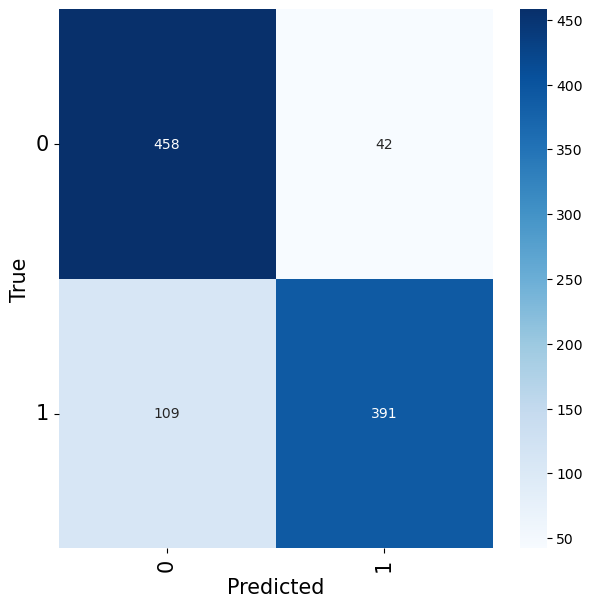

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_KNN.png')
plt.show()

##Logistic Regression

###Used In  Binary and Multiclass Classifications

In [118]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [119]:
features__.shape

(9605, 64)

In [120]:
...
# define the multinomial logistic regression model
lrm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lrm.fit(features__ , y_train)
y_pred_lr=lrm.predict(f___test)

In [121]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred_lr)
acc

0.757

In [122]:
precision_score(y_test,y_pred_lr,average=None)

array([0.72987478, 0.79138322])

In [123]:
recall_score(y_test,y_pred_lr,average=None)

array([0.816, 0.698])

In [124]:
f1_score(y_test,y_pred_lr,average=None)

array([0.77053824, 0.74176408])

In [125]:
cm = confusion_matrix(y_test,y_pred_lr)
cm

array([[408,  92],
       [151, 349]], dtype=int64)

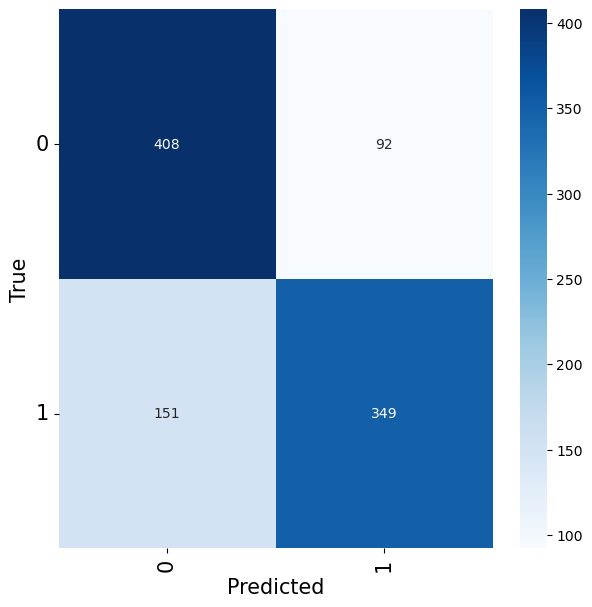

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/XceptionLR.png')
plt.show()

In [127]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred_lr)
acc

0.757

In [128]:
#precision_score(y_test,y_pred,average=None)

In [129]:
#metrics.f1_score(y_test,y_pred,average=None)

##Random Forest

In [130]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [131]:
# Train the model on training data
RF_model.fit(features__, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [132]:
print(RF_model.score(features__, y_train))

0.9995835502342529


In [133]:
#Send test data through same feature extractor process
X_test_feature = Model.predict(x_test)



32/32 [==============================] - 2s 64ms/step


In [134]:
X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [135]:
print(X_test_feature.shape)

(1000, 2, 32)


In [136]:
#Now predict using the trained RF model.
prediction_RF = RF_model.predict(X_test_features__)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

In [137]:
print(prediction_RF.shape)

(1000,)


In [138]:
print(test_labels.shape)

(1000,)


In [139]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.867


In [140]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))
print("Precision =", precision_score(test_labels,prediction_RF,average='micro'))
print("Recall =",recall_score(test_labels,prediction_RF,average='micro'))
print("F_1 =", f1_score(test_labels,prediction_RF,average='micro'))

Accuracy =  0.867
Precision = 0.867
Recall = 0.867
F_1 = 0.867


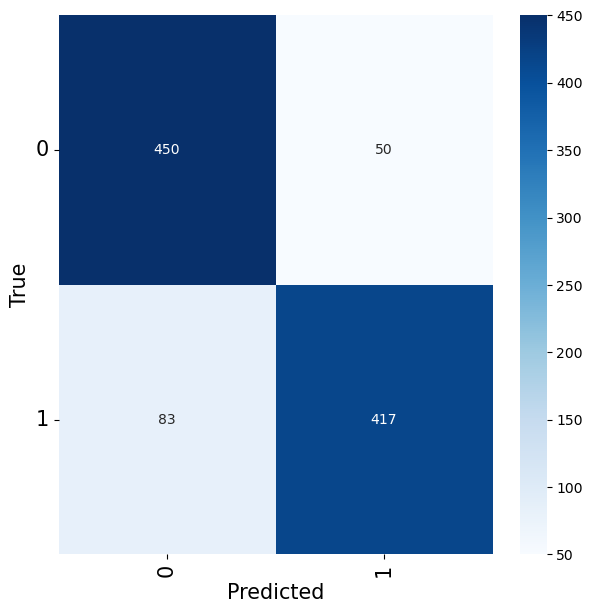

In [141]:
cm = confusion_matrix(test_labels,prediction_RF)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_RandomForest.png')
plt.show()

##XGBoost

In [142]:
import xgboost as xgb

In [143]:
xgb_classifier = xgb.XGBClassifier(tree_method = "auto")

In [144]:
xgb_classifier.fit(features__, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [145]:
predictions = xgb_classifier.predict(X_test_features__)
prediction_XG = le.inverse_transform(predictions)

In [146]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_XG))

Accuracy of Model:: 0.87


In [147]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_XG))
print("Precision =", precision_score(test_labels, prediction_XG,average='micro'))
print("Recall =",recall_score(test_labels, prediction_XG,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_XG,average='micro'))

Accuracy =  0.87
Precision = 0.87
Recall = 0.87
F_1 = 0.87


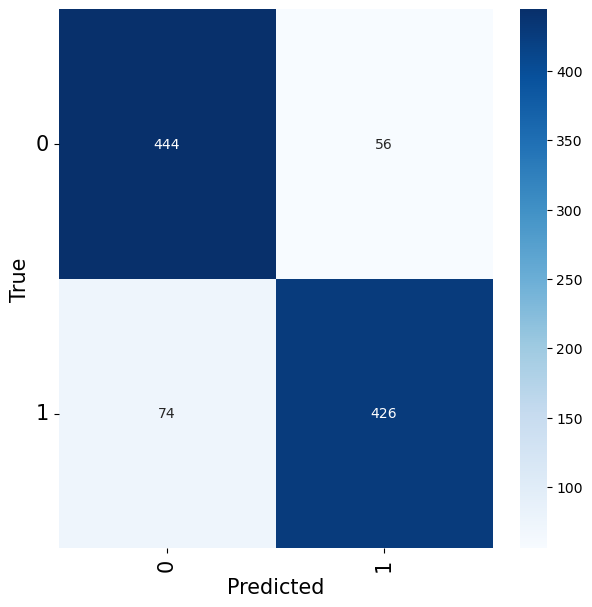

In [148]:
cm = confusion_matrix(test_labels, prediction_XG)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_XGBoost.png')
plt.show()

##SVC- Support Vector Classifier

In [149]:
from sklearn.svm import SVC

In [150]:
svc = SVC(C=0.65, random_state=0, kernel='rbf')

In [151]:
svc.fit(features__, y_train)

SVC(C=0.65, random_state=0)

In [152]:
X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)
X_test_features__.shape

(1000, 64)

In [153]:
X_test_features = Model.predict(x_test)
X_test_features.shape

32/32 [==============================] - 2s 67ms/step


(1000, 2, 32)

In [154]:
predictions = svc.predict(X_test_features__ )
prediction_SVC = le.inverse_transform(predictions)

In [155]:
prediction_SVC

array(['malignant', 'benign', 'malignant', 'malignant', 'malignant',
       'benign', 'malignant', 'benign', 'benign', 'benign', 'benign',
       'benign', 'malignant', 'benign', 'malignant', 'malignant',
       'malignant', 'benign', 'malignant', 'malignant', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'benign', 'malignant', 'malignant', 'benign', 'benign', 'benign',
       'malignant', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'malignant', 'malignant', 'benign', 'benign',
       'benign', 'malignant', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'malignant', 'benign', 'benign', 'malignant', 'benign',
       'benign', 'benign', 'malignant', 'benign', 'benign', 'malignant',
       'benign', 'benign', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignan

In [156]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_SVC))

Accuracy of Model:: 0.746


In [157]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))
print("Precision =", precision_score(test_labels, prediction_SVC,average='micro'))
print("Recall =",recall_score(test_labels, prediction_SVC,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_SVC,average='micro'))

Accuracy =  0.746
Precision = 0.746
Recall = 0.746
F_1 = 0.746


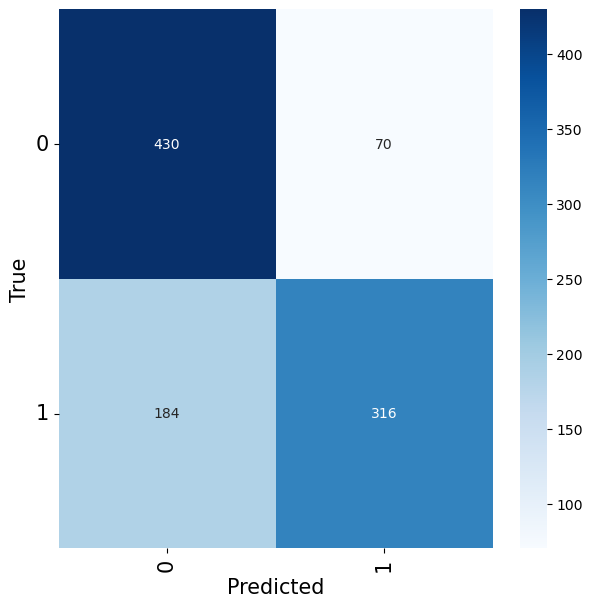

In [158]:
cm = confusion_matrix(test_labels, prediction_SVC)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_SVC.png')
plt.show()

In [159]:
# svc_1 = SVC(C=1, random_state=0, kernel='linear')

In [160]:
# svc_1.fit(features__, y_train)

In [161]:
# X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)
# X_test_features__.shape

In [162]:
# X_test_features = Model.predict(x_test)
# X_test_features.shape

In [163]:
# predictions = svc_1.predict(X_test_features__ )
# prediction_SVC = le.inverse_transform(predictions)

In [164]:
# prediction_SVC

In [165]:
# print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))
# print("Precision =", precision_score(test_labels, prediction_SVC,average='micro'))
# print("Recall =",recall_score(test_labels, prediction_SVC,average='micro'))
# print("Recall =", f1_score(test_labels, prediction_SVC,average='micro'))

In [166]:
import numpy as np
from sklearn.manifold import TSNE
#>>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(features__)
X_embedded.shape

(9605, 3)

In [167]:
import pandas as pd

In [168]:
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = X_embedded[:,0]
df["comp-2"] = X_embedded[:,1]

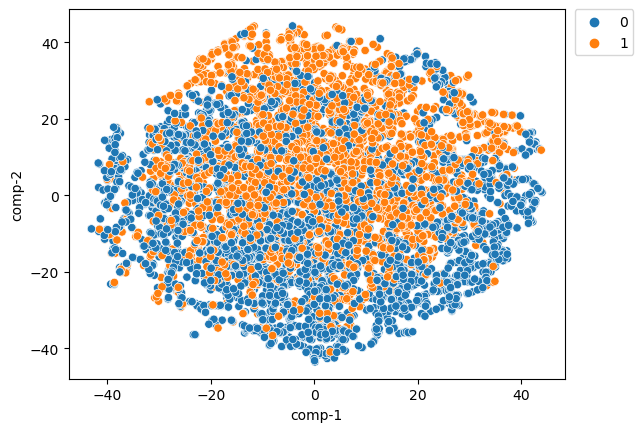

In [169]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig('/home/nd/Ankit-Deepto-Btech/__128_128/TSNE_Train_data.png')
plt.show()

In [170]:
# classfier_1.fit(features__, y_train)

In [171]:
# predictions_1 = classfier_1.predict(X_test_features__ )
# prediction_1 = le.inverse_transform(predictions_1)

In [172]:
# print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_1))

##ENSEMBLE

In [173]:
final_model_1 = VotingClassifier(estimators=[('rf', RF_model), ('xgb', xgb_classifier),('knn',knn),('svc',svc),('lr',lrm)], voting='hard')


In [174]:
final_model_1.fit(features__, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=Non...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('svc', SVC(C=0.65, random_state=0)),
                             ('lr',
                              LogisticRegression(multi_class='multinomial'))])

In [175]:
predictions = final_model_1.predict(X_test_features__) # X_test_features
prediction_final = le.inverse_transform(predictions)

In [176]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_final))

Accuracy of Model:: 0.856


In [177]:
print("Precision =", precision_score(test_labels, prediction_final,average='micro'))
print("Recall =",recall_score(test_labels, prediction_final,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_final,average='micro'))

Precision = 0.856
Recall = 0.856
F_1 = 0.856


In [178]:
print("Accuracy =",accuracy_score(test_labels, prediction_final))
print("Precision =", precision_score(test_labels, prediction_final,average=None))
print("Recall =",recall_score(test_labels, prediction_final,average=None))
print("F_1 =", f1_score(test_labels, prediction_final,average=None))

Accuracy = 0.856
Precision = [0.81338028 0.91203704]
Recall = [0.924 0.788]
F_1 = [0.86516854 0.84549356]


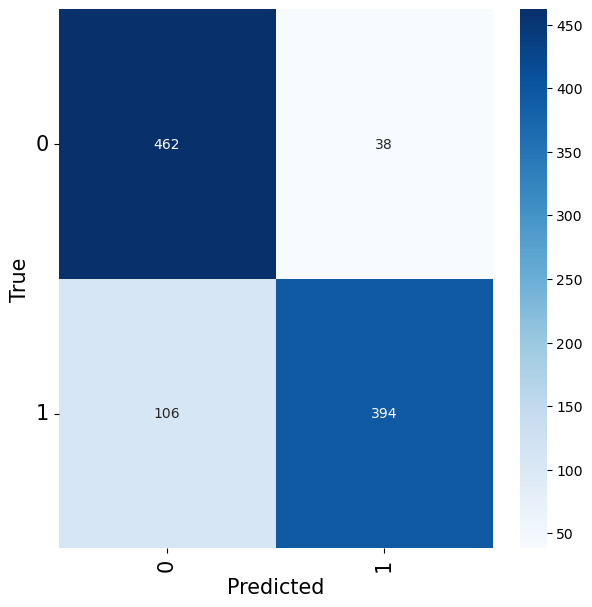

In [179]:
cm = confusion_matrix(test_labels, prediction_final)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_Ensemble.png')
plt.show()

# VGG19

In [180]:
Model = VGG19(weights='imagenet', include_top=False, input_shape=(128,128, 3))

In [181]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in Model.layers:
	layer.trainable = False

Model.summary()  #Trainable parameters will be 0

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [182]:
#Now, let us use features from convolutional network for RF
feature_extractor__=Model.predict(x_train)

301/301 [==============================] - 241s 800ms/step


In [183]:
fe___test=Model.predict(x_test)
#fe___test=MobileNet_model.predict(x_test)

32/32 [==============================] - 25s 770ms/step


In [184]:
features__ = feature_extractor__.reshape(feature_extractor__.shape[0], -1)

In [185]:
f___test=fe___test.reshape(fe___test.shape[0],-1)

In [186]:
print(f___test.shape)

(1000, 8192)


In [187]:
# X_for_RF = features__ #This is our X input to RF

#Machine Learning Models For Classifications

##K-Nearest Neighbours

In [188]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('seaborn-whitegrid')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [189]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(features__ , y_train)
y_pred=knn.predict(f___test)

In [190]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred)
acc

0.904

In [191]:
precision_score(y_test,y_pred,average='micro')

0.904

In [192]:
recall_score(y_test,y_pred,average='micro')

0.904

In [193]:
f1_score(y_test,y_pred,average='micro')

0.904

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix

In [195]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[482,  18],
       [ 78, 422]], dtype=int64)

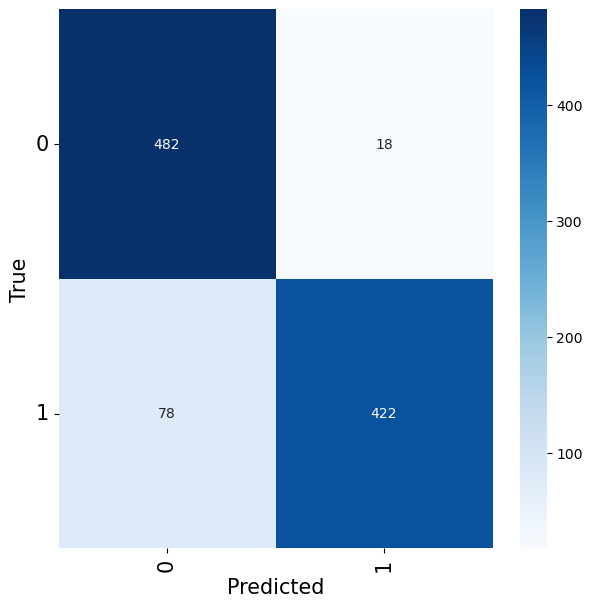

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_KNN.png')
plt.show()

##Logistic Regression

###Used In  Binary and Multiclass Classifications

In [197]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [198]:
features__.shape

(9605, 8192)

In [199]:
...
# define the multinomial logistic regression model
lrm = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lrm.fit(features__ , y_train)
y_pred_lr=lrm.predict(f___test)

C:\Users\lenovo\anaconda33\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [200]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred_lr)
acc

0.903

In [201]:
precision_score(y_test,y_pred_lr,average=None)

array([0.8974359 , 0.90872211])

In [202]:
recall_score(y_test,y_pred_lr,average=None)

array([0.91 , 0.896])

In [203]:
f1_score(y_test,y_pred_lr,average=None)

array([0.90367428, 0.90231621])

In [204]:
cm = confusion_matrix(y_test,y_pred_lr)
cm

array([[455,  45],
       [ 52, 448]], dtype=int64)

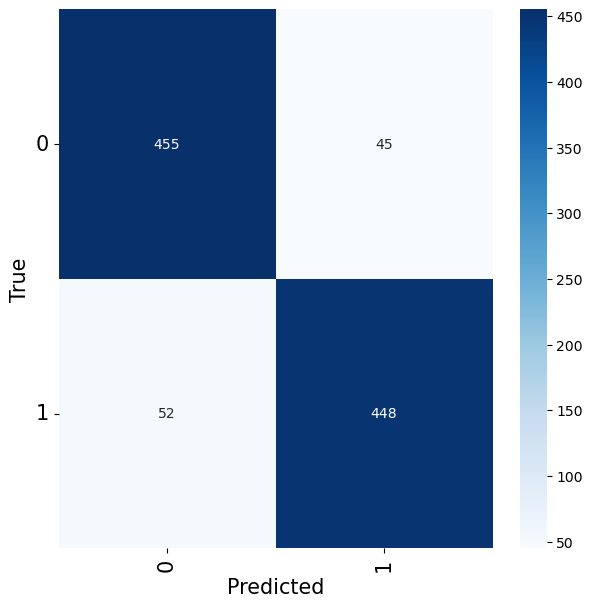

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/XceptionLR.png')
plt.show()

In [206]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score,   recall_score ,  f1_score
acc=accuracy_score(y_test,y_pred_lr)
acc

0.903

In [207]:
#precision_score(y_test,y_pred,average=None)

In [208]:
#metrics.f1_score(y_test,y_pred,average=None)

##Random Forest

In [209]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [210]:
# Train the model on training data
RF_model.fit(features__, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [211]:
print(RF_model.score(features__, y_train))

0.9998958875585633


In [212]:
#Send test data through same feature extractor process
X_test_feature = Model.predict(x_test)



32/32 [==============================] - 25s 779ms/step


In [213]:
X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)

In [214]:
print(X_test_feature.shape)

(1000, 4, 4, 512)


In [215]:
#Now predict using the trained RF model.
prediction_RF = RF_model.predict(X_test_features__)
#Inverse le transform to get original label back.
prediction_RF = le.inverse_transform(prediction_RF)

In [216]:
print(prediction_RF.shape)

(1000,)


In [217]:
print(test_labels.shape)

(1000,)


In [218]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.904


In [219]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))
print("Precision =", precision_score(test_labels,prediction_RF,average='micro'))
print("Recall =",recall_score(test_labels,prediction_RF,average='micro'))
print("F_1 =", f1_score(test_labels,prediction_RF,average='micro'))

Accuracy =  0.904
Precision = 0.904
Recall = 0.904
F_1 = 0.904


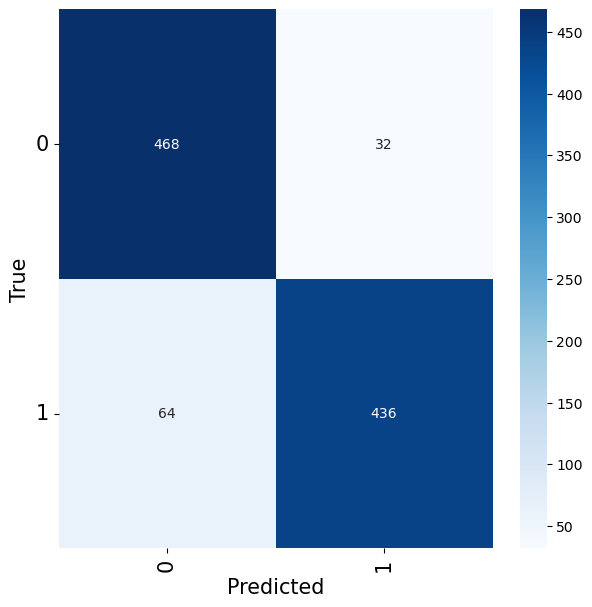

In [220]:
cm = confusion_matrix(test_labels,prediction_RF)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_RandomForest.png')
plt.show()

##XGBoost

In [221]:
import xgboost as xgb

In [222]:
xgb_classifier = xgb.XGBClassifier(tree_method = "auto")

In [223]:
xgb_classifier.fit(features__, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [224]:
predictions = xgb_classifier.predict(X_test_features__)
prediction_XG = le.inverse_transform(predictions)

In [225]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_XG))

Accuracy of Model:: 0.913


In [226]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_XG))
print("Precision =", precision_score(test_labels, prediction_XG,average='micro'))
print("Recall =",recall_score(test_labels, prediction_XG,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_XG,average='micro'))

Accuracy =  0.913
Precision = 0.913
Recall = 0.913
F_1 = 0.9130000000000001


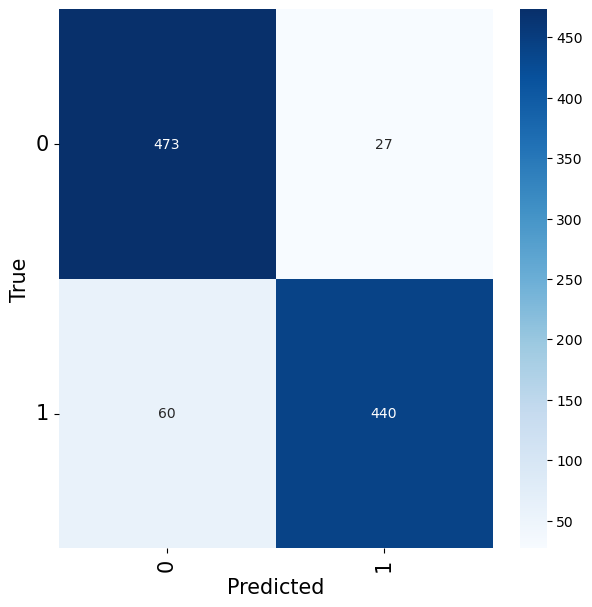

In [227]:
cm = confusion_matrix(test_labels, prediction_XG)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_XGBoost.png')
plt.show()

##SVC- Support Vector Classifier

In [228]:
from sklearn.svm import SVC

In [229]:
svc = SVC(C=0.65, random_state=0, kernel='rbf')

In [230]:
svc.fit(features__, y_train)

SVC(C=0.65, random_state=0)

In [231]:
X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)
X_test_features__.shape

(1000, 8192)

In [232]:
X_test_features = Model.predict(x_test)
X_test_features.shape

32/32 [==============================] - 25s 769ms/step


(1000, 4, 4, 512)

In [233]:
predictions = svc.predict(X_test_features__ )
prediction_SVC = le.inverse_transform(predictions)

In [234]:
prediction_SVC

array(['malignant', 'benign', 'malignant', 'benign', 'malignant',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'malignant', 'benign', 'benign', 'malignant',
       'malignant', 'malignant', 'benign', 'malignant', 'benign',
       'benign', 'malignant', 'benign', 'malignant', 'malignant',
       'benign', 'malignant', 'malignant', 'malignant', 'malignant',
       'benign', 'malignant', 'malignant', 'malignant', 'benign',
       'malignant', 'malignant', 'benign', 'malignant', 'malignant',
       'benign', 'benign', 'benign', 'benign', 'malignant', 'malignant',
       'malignant', 'malignant', 'benign', 'malignant', 'malignant',
       'benign', 'benign', 'benign', 'benign', 'benign', 'benign',
       'benign', 'malignant', 'benign', 'benign', 'benign', 'benign',
       'benign', 'benign', 'benign', 'malignant', 'benign', 'malignant',
       'malignant', 'benign', 'malignant', 'malignant', 'benign',
       'malignant', 'malignant', 'malignant', 'mal

In [235]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_SVC))

Accuracy of Model:: 0.912


In [236]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))
print("Precision =", precision_score(test_labels, prediction_SVC,average='micro'))
print("Recall =",recall_score(test_labels, prediction_SVC,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_SVC,average='micro'))

Accuracy =  0.912
Precision = 0.912
Recall = 0.912
F_1 = 0.912


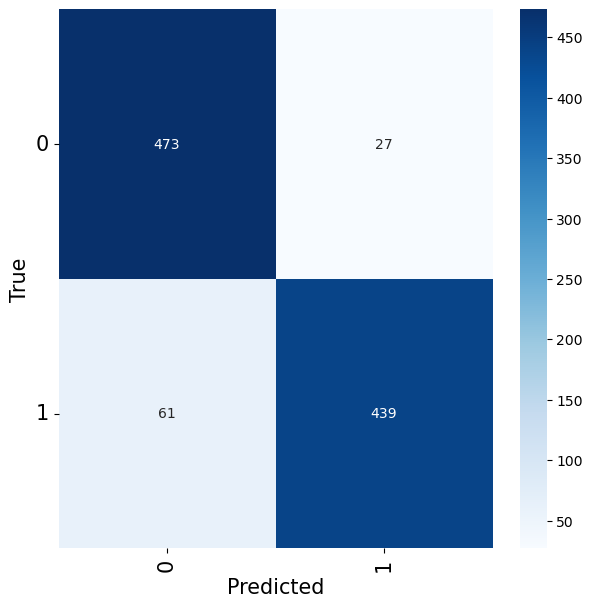

In [237]:
cm = confusion_matrix(test_labels, prediction_SVC)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_SVC.png')
plt.show()

In [238]:
# svc_1 = SVC(C=1, random_state=0, kernel='linear')

In [239]:
# svc_1.fit(features__, y_train)

In [240]:
# X_test_features__ = X_test_feature.reshape(X_test_feature.shape[0], -1)
# X_test_features__.shape

In [241]:
# X_test_features = Model.predict(x_test)
# X_test_features.shape

In [242]:
# predictions = svc_1.predict(X_test_features__ )
# prediction_SVC = le.inverse_transform(predictions)

In [243]:
# prediction_SVC

In [244]:
# print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVC))
# print("Precision =", precision_score(test_labels, prediction_SVC,average='micro'))
# print("Recall =",recall_score(test_labels, prediction_SVC,average='micro'))
# print("Recall =", f1_score(test_labels, prediction_SVC,average='micro'))

In [245]:
import numpy as np
from sklearn.manifold import TSNE
#>>> X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(features__)
X_embedded.shape

(9605, 3)

In [246]:
import pandas as pd

In [247]:
df = pd.DataFrame()
df["y"] = y_train
df["comp-1"] = X_embedded[:,0]
df["comp-2"] = X_embedded[:,1]

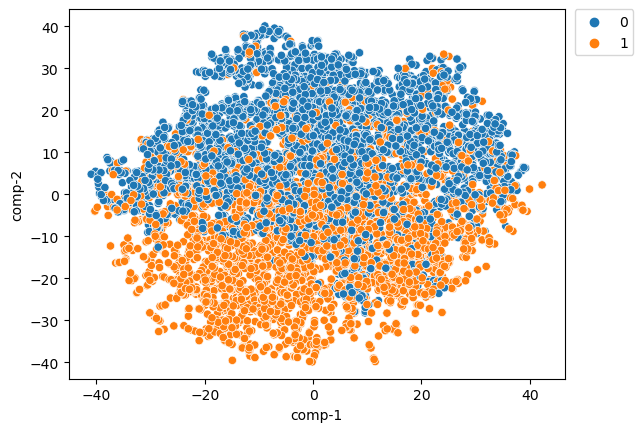

In [248]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.savefig('/home/nd/Ankit-Deepto-Btech/__128_128/TSNE_Train_data.png')
plt.show()

In [249]:
# classfier_1.fit(features__, y_train)

In [250]:
# predictions_1 = classfier_1.predict(X_test_features__ )
# prediction_1 = le.inverse_transform(predictions_1)

In [251]:
# print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_1))

##ENSEMBLE

In [252]:
final_model_2 = VotingClassifier(estimators=[('rf', RF_model), ('xgb', xgb_classifier),('knn',knn),('svc',svc),('lr',lrm)], voting='hard')


In [253]:
final_model_2.fit(features__, y_train)

C:\Users\lenovo\anaconda33\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=Non...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('knn', KNeighborsClassifier(n_neighbors=10)),
                             ('svc', SVC(C=0.65, random_state=0)),
                             ('lr',
                              LogisticRegression(multi_class='multinomial'))])

In [254]:
predictions = final_model_2.predict(X_test_features__) # X_test_features
prediction_final = le.inverse_transform(predictions)

In [255]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_final))

Accuracy of Model:: 0.915


In [256]:
print("Precision =", precision_score(test_labels, prediction_final,average='micro'))
print("Recall =",recall_score(test_labels, prediction_final,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_final,average='micro'))

Precision = 0.915
Recall = 0.915
F_1 = 0.915


In [257]:
print("Accuracy =",accuracy_score(test_labels, prediction_final))
print("Precision =", precision_score(test_labels, prediction_final,average=None))
print("Recall =",recall_score(test_labels, prediction_final,average=None))
print("F_1 =", f1_score(test_labels, prediction_final,average=None))

Accuracy = 0.915
Precision = [0.88497217 0.95010846]
Recall = [0.954 0.876]
F_1 = [0.91819057 0.91155047]


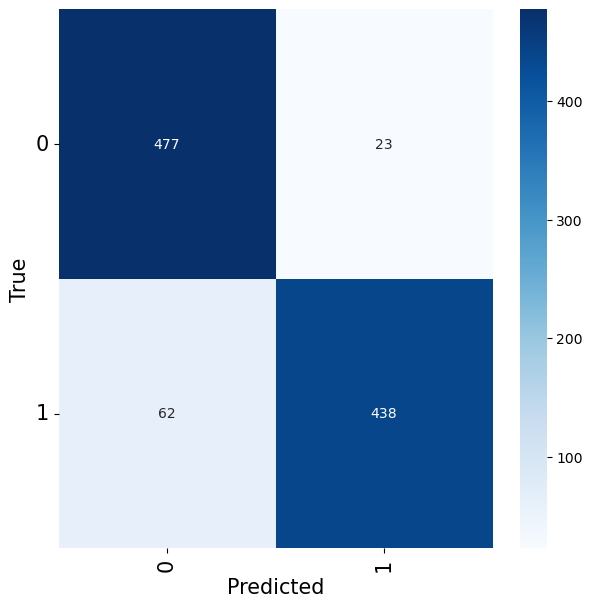

In [258]:
cm = confusion_matrix(test_labels, prediction_final)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/Xception_128_128/Xception_Ensemble.png')
plt.show()

# Ensemble of ensemble code

In [259]:
final_model_final= VotingClassifier(estimators=[('model0', final_model), ('model1', final_model_1),('model2',final_model_2)], voting='hard')


In [260]:
final_model_final.fit(features__, y_train)

C:\Users\lenovo\anaconda33\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lenovo\anaconda33\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

VotingClassifier(estimators=[('model0',
                              VotingClassifier(estimators=[('rf',
                                                            RandomForestClassifier(n_estimators=50,
                                                                                   random_state=42)),
                                                           ('xgb',
                                                            XGBClassifier(base_score=None,
                                                                          booster=None,
                                                                          callbacks=None,
                                                                          colsample_bylevel=None,
                                                                          colsample_bynode=None,
                                                                          colsample_bytree=None,
                                                                          early_stopping_rounds=None,
                                                                          enable_categorical=False,
                                                                          eval_metric=None,
                                                                          feature_types=None...
                                                                          max_cat_to_onehot=None,
                                                                          max_delta_step=None,
                                                                          max_depth=None,
                                                                          max_leaves=None,
                                                                          min_child_weight=None,
                                                                          missing=nan,
                                                                          monotone_constraints=None,
                                                                          n_estimators=100,
                                                                          n_jobs=None,
                                                                          num_parallel_tree=None,
                                                                          predictor=None,
                                                                          random_state=None, ...)),
                                                           ('knn',
                                                            KNeighborsClassifier(n_neighbors=10)),
                                                           ('svc',
                                                            SVC(C=0.65,
                                                                random_state=0)),
                                                           ('lr',
                                                            LogisticRegression(multi_class='multinomial'))]))])

In [261]:
predictions = final_model_final.predict(X_test_features__) # X_test_features
prediction_final = le.inverse_transform(predictions)

In [262]:
print("Accuracy of Model::",metrics.accuracy_score(test_labels, prediction_final))

Accuracy of Model:: 0.915


In [263]:
print("Precision =", precision_score(test_labels, prediction_final,average='micro'))
print("Recall =",recall_score(test_labels, prediction_final,average='micro'))
print("F_1 =", f1_score(test_labels, prediction_final,average='micro'))

Precision = 0.915
Recall = 0.915
F_1 = 0.915


In [264]:
print("Accuracy =",accuracy_score(test_labels, prediction_final))
print("Precision =", precision_score(test_labels, prediction_final,average=None))
print("Recall =",recall_score(test_labels, prediction_final,average=None))
print("F_1 =", f1_score(test_labels, prediction_final,average=None))

Accuracy = 0.915
Precision = [0.88497217 0.95010846]
Recall = [0.954 0.876]
F_1 = [0.91819057 0.91155047]


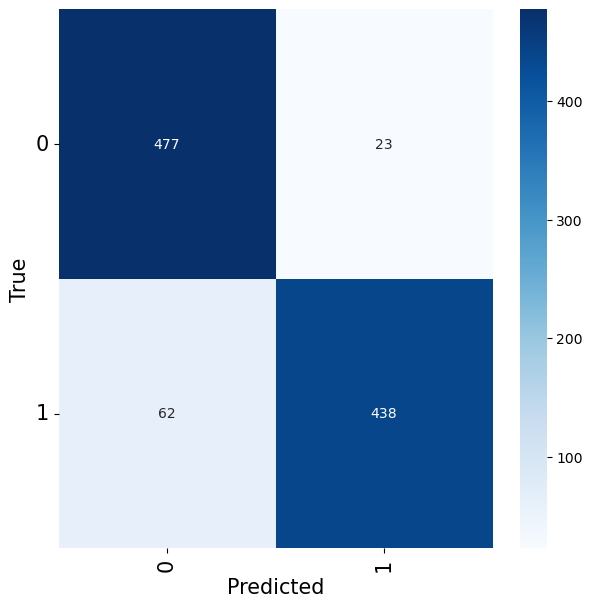

In [265]:
cm = confusion_matrix(test_labels, prediction_final)
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
#y_pred = np.argmax(predictions, axis=-1)

#y_true=np.argmax(y_test, axis=-1)

#cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
#labels = le.classes_
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(7, 7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues", fmt = "g"); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=15)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 15)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=15)
ax.yaxis.set_ticklabels(class_names, fontsize = 15)
plt.yticks(rotation=0)

#plt.title('Refined Confusion Matrix', fontsize=15)

# plt.savefig('/home/nd/Ankit-Deepto-Btech/ensemble_of_ensemble/confusion_matrix.png')
plt.show()